In [2]:
# Reference: L-BFGS-B options https://docs.scipy.org/doc/scipy/reference/optimize.minimize-lbfgsb.html
# PINN: https://github.com/omniscientoctopus/Physics-Informed-Neural-Networks

In [3]:
import tensorflow as tf
import datetime, os
#hide tf logs 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'} 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from numpy import linalg as LA
import itertools  
from scipy.optimize import Bounds
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [4]:
from sklearn import linear_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ShuffleSplit

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
# Important: t>0, u_x, u_xx output u[1:-1]
# Derivative formula: forward in time, central in space
def u_x(u, t, h):
    u_at_t = u[t]
    return (u_at_t[2:] - u_at_t[:-2]) / (2*h)

def u_xx(u, t, h):
    u_at_t = u[t]
    return (u_at_t[2:] - 2*u_at_t[1:-1] + u_at_t[:-2]) / h**2

def u_t(u, t, k):
    u_at_t1 = u[t]
    u_at_t2 = u[t+1]
    return (u_at_t2 - u_at_t1)/k

def u_tt(u, t, k):
    u_at_t1 = u[t]
    u_at_t2 = u[t+1]
    u_at_t3 = u[t+2]
    return (u_at_t3 - 2*u_at_t2 + u_at_t1)/ k**2

In [7]:
class Sequentialmodel(tf.Module): 
    def __init__(self, layers, X_u_t0, u_t0, X_f_train, eps, gamma, function, name=None):
        self.W = []  #Weights and biases
        self.parameters = 0 #total number of parameters
        self.layers_len = len(layers)
        self.X_u_t0 = X_u_t0
        self.X_f_train = X_f_train
        self.u_t0 = u_t0
        self.layers = layers
        self.eps = eps
        self.gamma = gamma
        self.func = function
        
        # initial the neural network layer
        for i in range(len(layers)-1):
            input_dim = layers[i]
            output_dim = layers[i+1]
            # Xavier standard deviation 
            std_dv = np.sqrt((2.0/(input_dim + output_dim)))

            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv
            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))
            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), 
                            trainable = True, name = 'b' + str(i+1))
            
            self.W.append(w)
            self.W.append(b)
            self.parameters +=  input_dim * output_dim + output_dim
    
    def evaluate(self,x):
        # Calculate the output with all hidden layer, 
        # but all hidden layer use same activation function: tanh(z)
        # where z = matrix.dot(X_sc , w) + b
        for i in range(self.layers_len-2):
            z = tf.add(tf.matmul(x, self.W[2*i]), self.W[2*i+1])
            x = tf.nn.tanh(z)
        
        x = tf.add(tf.matmul(x, self.W[-2]), self.W[-1]) # For regression, no activation to last layer
        return x
    
    def get_weights(self):
        parameters_1d = [] 
        for i in range (self.layers_len-1):
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        return parameters_1d
        
    def set_weights(self,parameters):
                
        for i in range (self.layers_len-1):
            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 

            
    def loss_ini(self,x,y):
        # Calculate the loss of boundary condition
        loss_u = tf.reduce_mean(tf.square(y - self.evaluate(x)))
        return loss_u

    def permutation_list(self,num):
        gamma_comb = []
        gamma_list = list(itertools.combinations(self.gamma,num))
        for gam_one in gamma_list:
            temp_gamma = 1
            for gam in gam_one:
                temp_gamma = temp_gamma * gam
            gamma_comb.append(temp_gamma)
        return gamma_comb

    def dF_u(self, u):
        F_u_result = 1
        for i in range(1,len(self.gamma)+2):
            F_u_result = F_u_result + \
                  (i+1)*(-1)**i * (np.sum(self.permutation_list(i-1)) + \
                                np.sum(self.permutation_list(i)))*u**i
        return F_u_result

    def loss_PDE(self, x_to_train_f):
        g = tf.Variable(x_to_train_f, dtype = 'float64', trainable = False)
        x_f = g[:,0].reshape(-1,1)
        t_f = g[:,1].reshape(-1,1)
        
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(x_f)
            tape.watch(t_f)
            g = tf.stack([x_f[:,0], t_f[:,0]], axis=1)  
            u = self.evaluate(g)
            u_x = tape.gradient(u,x_f)
            u_t = tape.gradient(u,t_f)    
            u_xx = tape.gradient(u_x, x_f)
        del tape
        left = u_t
        if self.func == 'Ex1':
            right = u_xx - u - u_x
        if self.func == 'Ex2':
            right = u_xx + u*(1-u)
        if self.func == 'Ex3':
            right = u_xx - u*u_x
        loss_comb = tf.reduce_mean(tf.square(left - right))
        return loss_comb

    def loss(self,x,y,g):
        loss_u = self.loss_ini(x,y)
        loss_f = self.loss_PDE(g)
        loss = loss_u + loss_f
        return loss, loss_u, loss_f
    
    # Gradient descent
    def optimizerfunc(self,parameters):
        self.set_weights(parameters)
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            loss_val, loss_u, loss_f = self.loss(self.X_u_t0, self.u_t0, self.X_f_train)
        # Derivate on each parameters: i.e: w1, b1, w2, b2
        grads = tape.gradient(loss_val,self.trainable_variables)    
        del tape
        
        grads_1d = [ ] #flatten grads 
        for i in range (len(self.layers)-1):
            grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights 
            grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases
            grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights 
            grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_biases
        return loss_val.numpy(), grads_1d.numpy()
    
    def optimizer_callback(self,parameters):  
        loss_value, loss_u, loss_f = self.loss(self.X_u_t0, self.u_t0, self.X_f_train)
        tf.print(loss_value, loss_u, loss_f)

In [8]:
# Inverse problem 
def optimize_linear(para, phi, ut, lam):
    zero_norm = np.sum(para != 0)
    return LA.norm(phi.dot(para.reshape(-1,1)) - ut.reshape(-1,1)) + lam * zero_norm

In [9]:
# Inverse problem for linear model
def linear_model_reg(model, split_num, head, phi, ut):
    # shuff_para, train_per, test_per = [], [], []
    shuff_para, all_per = [], []
    ss = ShuffleSplit(n_splits=split_num, test_size=0.25, random_state=0)

    for train_index, test_index in ss.split(phi):
        mod = model.fit(phi[train_index], ut[train_index])
        shuff_para.append(mod.coef_)

        # pred_test = mod.predict(phi[test_index])
        # pred_train = mod.predict(phi[train_index])
        pred_all = mod.predict(phi)
        all_per.append(mean_squared_error(pred_all, ut, squared=False))
        # test_per.append(mean_squared_error(pred_test, ut[test_index], squared=False))
        # train_per.append(mean_squared_error(pred_train, ut[train_index], squared=False))
    return shuff_para, all_per

def linear_reg_main(model, split_num, head, phi, ut, CV_th):
    shuff_para, all_per = linear_model_reg(model, split_num, head, phi, ut)
    shuff_x_sigma = np.sqrt(np.var(shuff_para, axis = 0, ddof=1))
    shuff_x_mean = np.mean(shuff_para, axis=0)
    shuff_x_cv_abs = np.abs(shuff_x_sigma/shuff_x_mean) 

    if len(head) == 1:
        return head, np.mean(shuff_para, axis=0), shuff_x_cv_abs, np.mean(all_per)

    elif 0 in shuff_x_mean:
        delete_index = np.argmax(-np.abs(shuff_x_mean))
        del head[delete_index]
        phi = np.delete(phi, delete_index, 1)
        return linear_reg_main(model, split_num, head, phi, ut, CV_th)    
    if np.max(shuff_x_cv_abs) > CV_th:
        delete_inde = np.argmax(shuff_x_cv_abs)
        del head[delete_inde]
        phi = np.delete(phi, delete_inde, 1)
        return linear_reg_main(model, split_num, head, phi, ut, CV_th)
    else:
        return head, np.mean(shuff_para, axis=0), shuff_x_cv_abs, np.mean(all_per)

In [10]:
# Inverse problem for minimize solver
def optmize_reg(opt_method, split_num, head, phi, lam, ut):
    shuff_para,all_per = [], []
    ss = ShuffleSplit(n_splits=split_num, test_size=0.25, random_state=0)
    
    for train_index, test_index in ss.split(phi):
        para0 = np.ones(phi.shape[1])
        opt_model = scipy.optimize.minimize(optimize_linear,  para0, args=(phi[train_index], ut[train_index], lam), 
                                  method=opt_method, tol=1e-16)
        shuff_para.append(opt_model.x)
        pred_train = phi.dot(opt_model.x.reshape(-1,1)).reshape(-1,) 
        all_per.append(mean_squared_error(pred_train, ut, squared=False))
    return shuff_para, all_per

def optmize_reg_main(opt_method, split_num, head, phi, lam, ut, CV_th):
    shuff_para, all_per = optmize_reg(opt_method, split_num, head, phi, lam, ut)
    shuff_x_sigma = np.sqrt(np.var(shuff_para, axis = 0, ddof=1))
    shuff_x_mean = np.mean(shuff_para, axis=0)
    shuff_x_cv_abs = np.abs(shuff_x_sigma/shuff_x_mean)
    if np.max(shuff_x_cv_abs) > CV_th:
        delete_inde = np.argmax(shuff_x_cv_abs)
        del head[delete_inde]
        phi = np.delete(phi, delete_inde, 1)
        return optmize_reg_main(opt_method, split_num, head, phi, lam, ut, CV_th)
    else:
        return head, np.mean(shuff_para, axis=0), shuff_x_cv_abs, np.mean(all_per)

In [11]:
def full_heads(or_head, new_head, values):
    output_head = {}
    for head in or_head:
        if head not in new_head:
            output_head[head] = 0
        else:
            output_head[head] = values[new_head.index(head)]
    return output_head

def linear_opt_main(Ridge_alpha, lasso_alpha, opt_method, split_num, head_or, phi_or, lam, ut, CV_th):
    head, phi = head_or.copy(), phi_or.copy()
    results = pd.DataFrame(columns=head+['Phi RMSE', 'Min ACV', 'Max ACV', 'Mean ACV'])
    linear_md = [linear_model.LinearRegression(), linear_model.Ridge(alpha=Ridge_alpha), 
                 linear_model.Lasso(alpha=lasso_alpha), linear_model.ARDRegression()]
    head_1, para_1, cv_abs_1, per_1 = optmize_reg_main(opt_method, split_num, head, phi, lam, ut, CV_th)
    val_1 = full_heads(head_or, head_1, para_1)
    val_1['Phi RMSE'] = per_1
    val_1['Min ACV'] = np.min(cv_abs_1)
    val_1['Max ACV'] = np.max(cv_abs_1)
    val_1['Mean ACV'] = np.mean(cv_abs_1)
    results.loc[0] = val_1
    m = 1
    for md in linear_md:
        print(md)
        head, phi = head_or.copy(), phi_or.copy()
        head_res, para, cv_abs, per = linear_reg_main(md, split_num, head, phi, ut, CV_th)
        val = full_heads(head_or, head_res, para)
        val['Phi RMSE'] = per
        val['Min ACV'] = np.min(cv_abs)
        val['Max ACV'] = np.max(cv_abs)
        val['Mean ACV'] = np.mean(cv_abs)
        results.loc[m] = val
        m += 1
    return results

In [12]:
def Phi_u(u, ux, uxx, ut, utt):
    u = u.reshape(-1,1)
    ux = ux.reshape(-1,1)
    uxx = uxx.reshape(-1,1)
    utt = utt.reshape(-1,1)
    ut = ut.reshape(-1,1)
    phi_head = ['u','u**2', 'u**3', 'u*ux', 'ux','uxx']
    phi_data = np.concatenate((u, u**2, u**3,u*ux, ux, uxx), axis=1)
    return phi_head, phi_data

In [13]:
# Define the initial value 
def ini_generate(tau , t_end , n, m, func_ex):
    x_t0 = np.linspace(-tau, tau, n).reshape(-1,1)
    t0 = np.linspace(0, t_end, m).reshape(-1,1)
    if func_ex == 'Ex1':
        u0 = (np.exp(-x_t0**2)).reshape(-1,1)
    if func_ex == 'Ex2':
        u0 = (1/(1+np.exp(5*x_t0))).reshape(-1,1)
    if func_ex == 'Ex3':
        u0 = (1/(1+np.exp(x_t0))).reshape(-1,1)
    x0, t0 = np.meshgrid(x_t0,t0)
    x0 = x0.reshape(-1,1)
    t0 = t0.reshape(-1,1)
    train_set = np.concatenate((x0, t0), axis=1)
    x_t0 = np.concatenate((x_t0, np.zeros(len(x_t0)).reshape(-1,1)), axis=1)
    return [train_set, x_t0, u0]

def test_generate(tau , t_end , n, m):
    x_test = np.random.uniform(-tau , tau , n).reshape(-1,1)
    t_test = np.random.uniform(0, t_end , m).reshape(-1,1)
    return np.concatenate((x_test, t_test), axis=1)

In [14]:
def x_t_generate(x_range,t_start, t_range, x_am, t_am):
    x_r = np.linspace(-x_range, x_range, x_am)
    t_r = np.linspace(t_start, t_range, t_am)

    x0, t0 = np.meshgrid(x_r,t_r)
    x0 = x0.reshape(-1,1)
    t0 = t0.reshape(-1,1)
    return np.concatenate((x0, t0), axis=1)

def x_y_z_generate(PINN_model, x_end, t_start, t_end, x_num, t_num):
    est_data = x_t_generate(x_end, t_start, t_end, x_num, t_num)
    u_est = PINN_model.evaluate(est_data)
    z = np.asarray(u_est).reshape(t_num, x_num)
    x = est_data[:,0].reshape(t_num, x_num)
    t = est_data[:,1].reshape(t_num, x_num)
    return z, x, t

In [15]:
# Example 1
x_end = 3
t_end = 3
eps = 0
gamma = [0]
layers = np.array([2,20,10,1])
x_num = 150
t_num = 150
k = 1
train_set, x_t0, u_t0 = ini_generate(x_end, t_end, x_num, t_num, 'Ex1')
test_set = test_generate(x_end, t_end, 10, 10)

In [16]:
PINN = Sequentialmodel(layers, x_t0, u_t0, 
                       train_set, eps, gamma, 'Ex1')

init_params = PINN.get_weights().numpy()

In [17]:
# optimize L-BFGS-B options https://docs.scipy.org/doc/scipy/reference/optimize.minimize-lbfgsb.html
# Minimize the objective function: fun(x, *args) -> float
# where x is a 1-D array with shape (n, ) 
# and *args is a tuple of the fixed parameters needed to completely specify the function.
results = scipy.optimize.minimize(fun = PINN.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = PINN.optimizer_callback, 
                                  options = {'disp': None,
                                            'maxcor': 200, 
                                            'ftol': 1e-12,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 1e-6, 
                                            'maxfun':  50000, 
                                            'maxiter': 5000,
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})

PINN.set_weights(results.x)

0.26056453226800042 0.19619521983608912 0.06436931243191131
0.20919540300468289 0.15685215721910603 0.052343245785576864
0.15746879338165595 0.11344767775793414 0.044021115623721817
0.11737685795596901 0.092120327388901108 0.025256530567067906
0.10202152170246448 0.081008274146229464 0.021013247556235015
0.0936236096257388 0.079231934044274713 0.014391675581464092
0.088636593624483062 0.076267396231671544 0.012369197392811513
0.085017754277031524 0.072865909287857258 0.012151844989174262
0.079772471569919984 0.066038996203517761 0.013733475366402223
0.0693091690069998 0.047310481262257849 0.021998687744741938
0.060471311646304496 0.037262156066200952 0.023209155580103547
0.049912743786181976 0.026005618739114968 0.023907125047067004
0.047814541426385707 0.023681342014054505 0.024133199412331205
0.038718455270852707 0.014957799257811938 0.023760656013040768
0.031987957421696696 0.012278221216685795 0.0197097362050109
0.029048067061109441 0.010693499586197279 0.01835456747491216
0.027600

In [18]:
t_start = 1
t_end = 2
x_end = 3
x_num = 500
t_num = 300
z_pinn, x_pinn, t_pinn = x_y_z_generate(PINN, x_end, t_start, t_end, x_num, t_num)

In [19]:
t_test = np.linspace(0, 100, 11)[1:-1]
for t in t_test:
    t = int(t)
    uxx=u_xx(z_pinn, t, x_pinn[0,1] - x_pinn[0,0])
    ux=u_x(z_pinn, t, x_pinn[0,1] - x_pinn[0,0])
    ut=u_t(z_pinn, t, t_pinn[1,0] - t_pinn[0,0])[1:-1]
    utt=u_tt(z_pinn, t, t_pinn[1,0] - t_pinn[0,0])[1:-1]
    u=z_pinn[t, 1:-1]

    print(mean_squared_error(ut, uxx - u - ux, squared = False))

0.00030284241242280294
0.00029489624467952214
0.0002949888186589224
0.00030183780503199647
0.0003135398384835587
0.0003280738773617954
0.0003436491437521469
0.0003588442393440582
0.0003726106304672794


In [20]:
t_start = 4
t_end = 5
x_end = 3
x_num = 500
t_num = 300
z_pinn, x_pinn, t_pinn = x_y_z_generate(PINN, x_end, t_start, t_end, x_num, t_num)

In [21]:
t_test = np.linspace(0, 100, 11)[1:-1]
for t in t_test:
    t = int(t)
    uxx=u_xx(z_pinn, t, x_pinn[0,1] - x_pinn[0,0])
    ux=u_x(z_pinn, t, x_pinn[0,1] - x_pinn[0,0])
    ut=u_t(z_pinn, t, t_pinn[1,0] - t_pinn[0,0])[1:-1]
    utt=u_tt(z_pinn, t, t_pinn[1,0] - t_pinn[0,0])[1:-1]
    u=z_pinn[t, 1:-1]

    print(mean_squared_error(ut, uxx - u - ux, squared = False))

0.004277143518733977
0.004463823405657561
0.004653819596706813
0.004847082491691954
0.005043563441644877
0.00524321474451913
0.0054459896340258405
0.005651842262832261
0.005860727680943511


In [22]:
t_start = 0
t_end = 3
x_end = 3
x_num = 200
t_num = 100
z_pinn, x_pinn, t_pinn = x_y_z_generate(PINN, x_end, t_start, t_end, x_num, t_num)

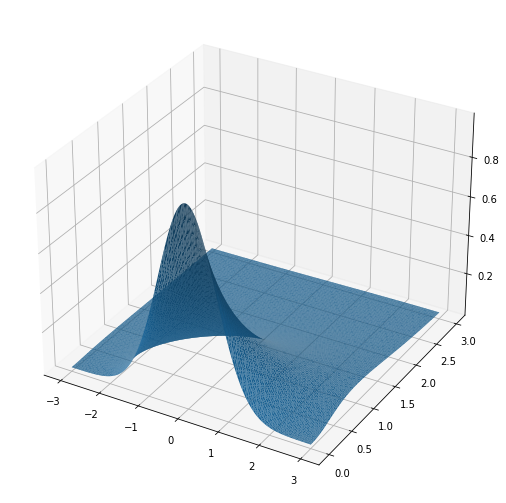

In [23]:
fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')
 
# Creating plot
ax.plot_trisurf(x_pinn.reshape(-1,), t_pinn.reshape(-1,), z_pinn.reshape(-1,),
                linewidth = 0.2,
                antialiased = True);
 
# show plot
plt.show()

In [24]:
t_start = 1
t_end = 2
x_end = 3
x_num = 300
t_num = 100
z_pinn, x_pinn, t_pinn = x_y_z_generate(PINN, x_end, t_start, t_end, x_num, t_num)

In [25]:
t_li = [20, 40, 60, 80]
uxx, ux, utt, ut, u = [], [], [], [], []
for t in t_li:
    uxx.append(u_xx(z_pinn, t, x_pinn[0,1] - x_pinn[0,0]))
    ux.append(u_x(z_pinn, t, x_pinn[0,1] - x_pinn[0,0]))
    ut.append(u_t(z_pinn, t, t_pinn[1,0] - t_pinn[0,0])[1:-1])
    utt.append(u_tt(z_pinn, t, t_pinn[1,0] - t_pinn[0,0])[1:-1])
    u.append(z_pinn[t, 1:-1])

uxx = np.asarray(uxx).reshape(-1,)
ux = np.asarray(ux).reshape(-1,)
utt = np.asarray(utt).reshape(-1,)
ut = np.asarray(ut).reshape(-1,)
u = np.asarray(u).reshape(-1,)

print(mean_squared_error(ut, uxx - u - ux, squared = False))
head, phi = Phi_u(u, ux, uxx, ut, utt)
print(head)

0.0006879510170885536
['u', 'u**2', 'u**3', 'u*ux', 'ux', 'uxx']


In [26]:
linear_opt_main(0.01, 0.001, 'L-BFGS-B', 200, head, phi, 0.001, ut, 0.01)

LinearRegression()
Ridge(alpha=0.01)
Lasso(alpha=0.001)
ARDRegression()


,u,u**2,u**3,u*ux,ux,uxx,Phi RMSE,Min ACV,Max ACV,Mean ACV
0,-0.995327,0,0,0,-0.979867,0.987609,0.000216,0.000102,0.000443,0.000259
1,-0.993915,0,0,0,-0.979870,0.990190,0.000215,0.000223,0.000638,0.000380
2,-1.041074,0,0,0,-0.922459,0.829912,0.001258,0.001934,0.006152,0.003607
3,-0.352279,0,0,0,0.000000,0.000000,0.034377,0.058582,0.058582,0.058582
4,-0.993915,0,0,0,-0.979870,0.990189,0.000215,0.000223,0.000638,0.000380


In [27]:
x_end = 3
t_end = 3
eps = 0
gamma = [0]
layers = np.array([2,20,10,1])
x_num = 150
t_num = 150
k = 1
train_set, x_t0, u_t0 = ini_generate(x_end, t_end, x_num, t_num, 'Ex2')
test_set = test_generate(x_end, t_end, 10, 10)

In [28]:
PINN2 = Sequentialmodel(layers, x_t0, u_t0, 
                       train_set, eps, gamma, 'Ex2')

init_params = PINN2.get_weights().numpy()

In [29]:
results = scipy.optimize.minimize(fun = PINN2.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = PINN2.optimizer_callback, 
                                  options = {'disp': None,
                                            'maxcor': 200, 
                                            'ftol': 1e-12,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 1e-6, 
                                            'maxfun':  50000, 
                                            'maxiter': 5000,
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})

PINN2.set_weights(results.x)

0.26124058920644766 0.22829594863719521 0.032944640569252441
0.13572641977962144 0.10518182866707666 0.030544591112544768
0.030636477319842231 0.022068727029755614 0.0085677502900866152
0.025173739696013497 0.017051173523028106 0.00812256617298539
0.021644606550016959 0.016432950079177121 0.0052116564708398361
0.020601635699796284 0.016176215257548473 0.0044254204422478106
0.019742281093265167 0.01574914358838472 0.003993137504880449
0.018566013772404924 0.014798755769599735 0.0037672580028051887
0.017443747609180566 0.013371738568134003 0.0040720090410465643
0.0164016742011034 0.01174194101965524 0.0046597331814481596
0.015721205386412841 0.010471445509649607 0.0052497598767632329
0.01486087208632368 0.00929597556346113 0.00556489652286255
0.014388247612758174 0.0083009501213459416 0.0060872974914122314
0.014145461773719479 0.008090274879007632 0.006055186894711846
0.013718920191737058 0.00796071045617789 0.0057582097355591676
0.013193742294999384 0.0079636814250384439 0.0052300608699

In [52]:
t_start = 1
t_end = 2
x_end = 3
x_num = 500
t_num = 300
z_pinn, x_pinn, t_pinn = x_y_z_generate(PINN2, x_end, t_start, t_end, x_num, t_num)

In [53]:
t_test = np.linspace(0, 100, 11)[1:-1]
for t in t_test:
    t = int(t)
    uxx=u_xx(z_pinn, t, x_pinn[0,1] - x_pinn[0,0])
    ux=u_x(z_pinn, t, x_pinn[0,1] - x_pinn[0,0])
    ut=u_t(z_pinn, t, t_pinn[1,0] - t_pinn[0,0])[1:-1]
    utt=u_tt(z_pinn, t, t_pinn[1,0] - t_pinn[0,0])[1:-1]
    u=z_pinn[t, 1:-1]

    print(mean_squared_error(ut, uxx + u*(1-u), squared = False))

0.0006675331524574072
0.0006680882741341538
0.0006671741834084779
0.0006660202599150905
0.0006642807129508863
0.0006606014909767579
0.000653356031136045
0.0006412455781830685
0.0006236469386748278


In [54]:
t_start = 4
t_end = 5
x_end = 3
x_num = 500
t_num = 300
z_pinn, x_pinn, t_pinn = x_y_z_generate(PINN2, x_end, t_start, t_end, x_num, t_num)

In [55]:
t_test = np.linspace(0, 100, 11)[1:-1]
for t in t_test:
    t = int(t)
    uxx=u_xx(z_pinn, t, x_pinn[0,1] - x_pinn[0,0])
    ux=u_x(z_pinn, t, x_pinn[0,1] - x_pinn[0,0])
    ut=u_t(z_pinn, t, t_pinn[1,0] - t_pinn[0,0])[1:-1]
    utt=u_tt(z_pinn, t, t_pinn[1,0] - t_pinn[0,0])[1:-1]
    u=z_pinn[t, 1:-1]

    print(mean_squared_error(ut, uxx + u*(1-u), squared = False))

0.007970492184919027
0.008309042333438368
0.00865346149872471
0.009003668020576228
0.00935957667783926
0.009721098399305152
0.010088140031248057
0.010460604161016414
0.010838388993954015


In [56]:
t_start = 0
t_end = 3
x_end = 3
x_num = 200
t_num = 100
z_pinn, x_pinn, t_pinn = x_y_z_generate(PINN2, x_end, t_start, t_end, x_num, t_num)

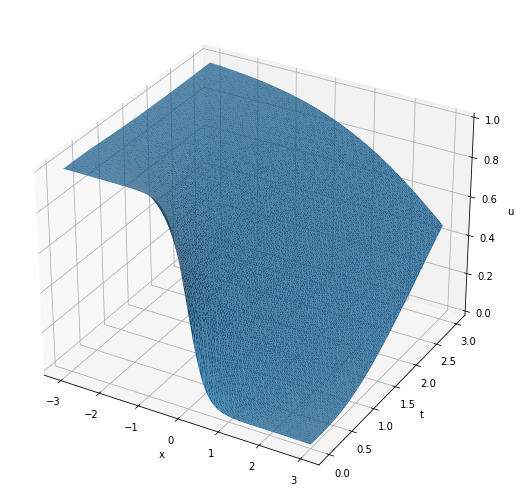

In [57]:
fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')
 
# Creating plot
ax.plot_trisurf(x_pinn.reshape(-1,), t_pinn.reshape(-1,), z_pinn.reshape(-1,),
                linewidth = 0.2,
                antialiased = True);
 
# show plot
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u')

In [36]:
t_start = 1
t_end = 2
x_end = 3
x_num = 300
t_num = 100
z_pinn, x_pinn, t_pinn = x_y_z_generate(PINN2, x_end, t_start, t_end, x_num, t_num)

In [59]:
t_li = [20, 40, 60, 80]
uxx, ux, utt, ut, u = [], [], [], [], []
for t in t_li:
    uxx.append(u_xx(z_pinn, t, x_pinn[0,1] - x_pinn[0,0]))
    ux.append(u_x(z_pinn, t, x_pinn[0,1] - x_pinn[0,0]))
    ut.append(u_t(z_pinn, t, t_pinn[1,0] - t_pinn[0,0])[1:-1])
    utt.append(u_tt(z_pinn, t, t_pinn[1,0] - t_pinn[0,0])[1:-1])
    u.append(z_pinn[t, 1:-1])

uxx = np.asarray(uxx).reshape(-1,)
ux = np.asarray(ux).reshape(-1,)
utt = np.asarray(utt).reshape(-1,)
ut = np.asarray(ut).reshape(-1,)
u = np.asarray(u).reshape(-1,)

print(mean_squared_error(ut, uxx + u*(1-u), squared = False))
head, phi = Phi_u(u, ux, uxx, ut, utt)

0.0017187774986465816


In [60]:
re_tab = linear_opt_main(0.01, 0.001, 'L-BFGS-B', 200, head, phi, 0.001, ut, 0.01)
re_tab

LinearRegression()
Ridge(alpha=0.01)
Lasso(alpha=0.001)
ARDRegression()


,u,u**2,u**3,u*ux,ux,uxx,Phi RMSE,Min ACV,Max ACV,Mean ACV
0,0.996553,-0.995917,0,0,0,0.999054,0.001646,0.000195,0.001001,0.000473
1,0.970018,-0.978421,0,0,0,0.972239,0.000855,0.000509,0.000810,0.000688
2,0.761490,-0.434121,-0.341651,0.481391,-0.257037,0.851905,0.001517,0.001557,0.005237,0.003539
3,0.000000,0.000000,-0.287456,0,0,0.000000,0.045488,0.009779,0.009779,0.009779
4,0.970017,-0.978420,0,0,0,0.972238,0.000855,0.000509,0.000810,0.000688


In [61]:
target = [1, -1, 0, 0, 0, 1]
for i in range(len(re_tab)):
    print(mean_squared_error(re_tab.iloc[i,:6], target, squared=False))


0.002215331549349058
0.01886473870510826
0.36823184147887705
0.7167787580733672
0.018865630814383843


In [39]:
# Example 3

x_end = 3
t_end = 3
eps = 0
gamma = [0]
layers = np.array([2,20,10,1])
x_num = 150
t_num = 150
k = 1
train_set, x_t0, u_t0 = ini_generate(x_end, t_end, x_num, t_num, 'Ex3')
test_set = test_generate(x_end, t_end, 10, 10)

In [40]:
PINN3 = Sequentialmodel(layers, x_t0, u_t0, 
                       train_set, eps, gamma, 'Ex3')

init_params = PINN3.get_weights().numpy()

In [41]:
results = scipy.optimize.minimize(fun = PINN3.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = PINN3.optimizer_callback, 
                                  options = {'disp': None,
                                            'maxcor': 200, 
                                            'ftol': 1e-12,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 1e-6, 
                                            'maxfun':  50000, 
                                            'maxiter': 5000,
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})

PINN3.set_weights(results.x)

0.15159974431386838 0.14277879242614847 0.0088209518877199172
0.0718985031447759 0.061951518083669443 0.0099469850611064638
0.022487204528945134 0.014045831119475959 0.0084413734094691759
0.017948793807912436 0.01039719899159559 0.0075515948163168457
0.014096995573405074 0.008512662154866046 0.0055843334185390293
0.011630419134210663 0.0072466946100001872 0.0043837245242104748
0.0071523988939419907 0.0038795323097626723 0.0032728665841793183
0.0039953791856726529 0.0015705722594934717 0.0024248069261791814
0.0025995007507400663 0.00081522613886372147 0.0017842746118763447
0.0011445590266499581 8.642150170550672e-05 0.0010581375249444514
0.00084588489454483272 1.9777418096872032e-05 0.0008261074764479607
0.0006687058307245521 2.5789971170557937e-05 0.00064291585955399415
0.00044379115736887403 6.3056602723868754e-05 0.0003807345546450053
0.00039171483914523988 6.160843825441969e-05 0.0003301064008908202
0.00037503490929595684 5.2625223632756883e-05 0.00032240968566319995
0.0003663690002

In [42]:
t_start = 1
t_end = 2
x_end = 3
x_num = 500
t_num = 300
z_pinn, x_pinn, t_pinn = x_y_z_generate(PINN3, x_end, t_start, t_end, x_num, t_num)

In [43]:
t_test = np.linspace(0, 100, 11)[1:-1]
for t in t_test:
    t = int(t)
    uxx=u_xx(z_pinn, t, x_pinn[0,1] - x_pinn[0,0])
    ux=u_x(z_pinn, t, x_pinn[0,1] - x_pinn[0,0])
    ut=u_t(z_pinn, t, t_pinn[1,0] - t_pinn[0,0])[1:-1]
    utt=u_tt(z_pinn, t, t_pinn[1,0] - t_pinn[0,0])[1:-1]
    u=z_pinn[t, 1:-1]

    print(mean_squared_error(ut, uxx - u*ux, squared = False))

0.0002564053807995459
0.00025440744339376496
0.0002572222118880569
0.0002639753066007738
0.00027357409631207356
0.00028490414250429455
0.0002969586557023907
0.00030889602371605144
0.00032004902314840906


In [44]:
t_start = 4
t_end = 5
x_end = 3
x_num = 500
t_num = 300
z_pinn, x_pinn, t_pinn = x_y_z_generate(PINN3, x_end, t_start, t_end, x_num, t_num)

In [45]:
t_test = np.linspace(0, 100, 11)[1:-1]
for t in t_test:
    t = int(t)
    uxx=u_xx(z_pinn, t, x_pinn[0,1] - x_pinn[0,0])
    ux=u_x(z_pinn, t, x_pinn[0,1] - x_pinn[0,0])
    ut=u_t(z_pinn, t, t_pinn[1,0] - t_pinn[0,0])[1:-1]
    utt=u_tt(z_pinn, t, t_pinn[1,0] - t_pinn[0,0])[1:-1]
    u=z_pinn[t, 1:-1]

    print(mean_squared_error(ut, uxx - u*ux, squared = False))

0.007992930069356925
0.008325026092720324
0.008661831519386822
0.009003177766009863
0.009348894972277425
0.009698812179715799
0.010052757506702984
0.010410558318998342
0.010772041396498497


In [46]:
t_start = 0
t_end = 3
x_end = 3
x_num = 200
t_num = 100
z_pinn, x_pinn, t_pinn = x_y_z_generate(PINN3, x_end, t_start, t_end, x_num, t_num)

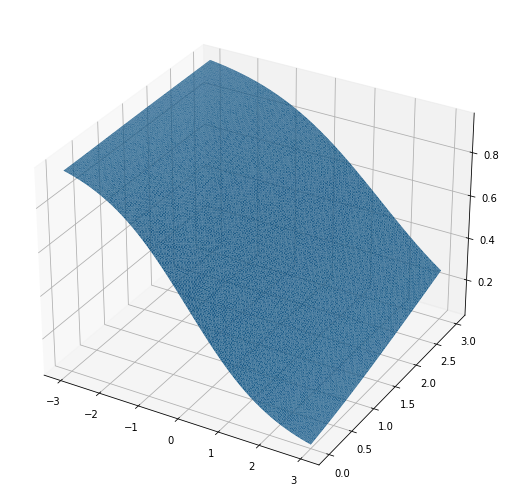

In [47]:
fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')
 
# Creating plot
ax.plot_trisurf(x_pinn.reshape(-1,), t_pinn.reshape(-1,), z_pinn.reshape(-1,),
                linewidth = 0.2,
                antialiased = True);
 
# show plot
plt.show()

In [48]:
t_start = 1
t_end = 2
x_end = 3
x_num = 300
t_num = 100
z_pinn, x_pinn, t_pinn = x_y_z_generate(PINN3, x_end, t_start, t_end, x_num, t_num)

In [49]:
t_li = [20,40, 60, 80]
uxx, ux, utt, ut, u = [], [], [], [], []
for t in t_li:
    uxx.append(u_xx(z_pinn, t, x_pinn[0,1] - x_pinn[0,0]))
    ux.append(u_x(z_pinn, t, x_pinn[0,1] - x_pinn[0,0]))
    ut.append(u_t(z_pinn, t, t_pinn[1,0] - t_pinn[0,0])[1:-1])
    utt.append(u_tt(z_pinn, t, t_pinn[1,0] - t_pinn[0,0])[1:-1])
    u.append(z_pinn[t, 1:-1])

uxx = np.asarray(uxx).reshape(-1,)
ux = np.asarray(ux).reshape(-1,)
utt = np.asarray(utt).reshape(-1,)
ut = np.asarray(ut).reshape(-1,)
u = np.asarray(u).reshape(-1,)

print(mean_squared_error(ut, uxx - u*ux, squared = False))
head, phi = Phi_u(u, ux, uxx, ut, utt)
print(head)

0.0003233934368718031
['u', 'u**2', 'u**3', 'u*ux', 'ux', 'uxx']


In [50]:
linear_opt_main(0.01, 0.001, 'L-BFGS-B', 200, head, phi, 0.001, ut, 0.01)

LinearRegression()
Ridge(alpha=0.01)
Lasso(alpha=0.001)
ARDRegression()


,u,u**2,u**3,u*ux,ux,uxx,Phi RMSE,Min ACV,Max ACV,Mean ACV
0,0,0,0,-0.999094,0,0.997998,0.000310,0.000080,0.000131,0.000105
1,0,0,0,-0.998640,0,0.997808,0.000310,0.000164,0.000260,0.000212
2,0,-0.031647,0,0.000000,-0.420955,0.219763,0.000700,0.001344,0.005788,0.003842
3,0,0,-0.103534,0.000000,0,0.000000,0.008983,0.004673,0.004673,0.004673
4,0,0,0,-0.998640,0,0.997808,0.000310,0.000164,0.000260,0.000212
